In [1]:
# ----------------------------------------------------------------------------
# Title:  AI-Assisted Self-Image Analysis for Depression-Risk Research
# ----------------------------------------------------------------------------
#
# Overview
# ========
# This repository accompanies the article
# **“Prediction of depression risk based on AI art prompts ”**
# It contains a single, self-contained Python workflow that reproduces the
# descriptive statistics, correlation analyses, group comparisons, basic
# regression models and classification models reported in the manuscript.
#
#
# Key Features
# ------------
# 1. **Colab-ready, but platform-agnostic**
#    If the notebook runs inside *Google Colab*, it auto-mounts Drive; otherwise
#    it treats `BASE_DIR` as a local path.
#
# 2. **Pre-aggregated input**
#    The CSV already stores one row per participant with prompt-level sentiment
#    distributions (mean, SD, five-number summary) so the workflow stays light.
#
# 3. **Two clinically motivated cut-offs**
#    The columns `depression_group16` and `depression_group19` let you
#    replicate both the *standard* (≥16) and *stricter* (≥19) thresholds of
#    the 9-item Beck Depression Inventory in a single run.
#
# 4. **Modular analysis pipelines**
#    * **Exploratory statistics** – histograms, power calculation, gender × risk
#      contingency tables.
#    * **Correlation pipeline** – Pearson r, bootstrap CIs, scatterplots,
#      publication-quality p-value barplots; results exported to .xlsx.
#    * **Group-comparison pipeline** – t-tests (with effect-size shading),
#      boxplots, sentiment-ratio pie charts.
#    * **Predictive modelling** – VIF-filtered OLS and a robust GLM variant.
#    * **Machine learning classificiation** – Several basic ML models are employed - with hiperparameter-tuning and threshold-optimisation.
#
# Dependencies
# ------------
# Python ≥3.10; core stack: `numpy`, `pandas`, `matplotlib`, `seaborn`,
# `scipy`, `statsmodels`
#
# Directory Layout
# ----------------
# .
# ├── analysis.py             # <-- the script / notebook exported as .py
# ├── aggregated_prompts.csv  # one row per participant (not included here)
# ├── /figures                # auto-generated on first run
# └── /excel                  # auto-generated on first run
#
# Licence
# -------
# MIT Licence for the code; the anonymised prompt-level dataset is released
# under CC-BY-4.0 as detailed in the OSF record cited in the article.
#
# Citing
# ------
# If you build on this pipeline, please cite the original paper:
#
# Kellerwessel, K. (2024). *Prediction of depression risk based on AI art
# prompts.* Unpublished manuscript.  DOI: 10.21203/rs.3.rs-5578681/v1
#
# Contributions & Issues
# ----------------------
# Pull requests are welcome for bug-fixes or generalisation to other
# psychological constructs (e.g., Big Five traits).
# If you have any questions, I'm ready to answer: **kellerwesselklaus @ gmail.com**.
#
# Happy analysing!
# ----------------------------------------------------------------------------

In [8]:
# ----------------------------------------------------------------------------
# 0 ▸ Mount Google Drive only if running inside Google Colab
# ----------------------------------------------------------------------------
# This block checks if the script is running in a Colab environment.
# If so, it imports and mounts Google Drive to access files.
# Otherwise, it continues as a standard local Python script.

import sys
import os
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = Path("/content/drive/My Drive")
else:
    # Replace this with your own local path where your data is stored
    BASE_DIR = Path("/your/local/folder/path")

# ----------------------------------------------------------------------------
# 1 ▸ Imports
# ----------------------------------------------------------------------------

# Standard library imports
import os
import math
from pathlib import Path

# Third-party library imports – scientific computing
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical functions
import scipy.stats as st
from scipy.stats import pearsonr, linregress, ttest_ind

# Statsmodels for regression and diagnostics
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import omni_normtest, jarque_bera


# ----------------------------------------------------------------------------
# 2 ▸ Configuration – you only need to set BASE_DIR
# ----------------------------------------------------------------------------
# These paths are now relative to BASE_DIR, which changes depending on environment

DATA_PATH = BASE_DIR / "AI_Assisted_Self_Image_Prompts_And_Personality_Tests_Aggregated.xlsx"
OUT_DIR   = BASE_DIR / "Figures_Generated"
OUT_DIR.mkdir(parents=True, exist_ok=True)


# ---------------------------------------------------------------------------
# 3 ▸ Load data
# ---------------------------------------------------------------------------
# The CSV already contains **one row per participant** with pre‑aggregated
# sentiment statistics (see Section 2.4 of the paper for details).

data = pd.read_excel(DATA_PATH)
print("First five rows of the dataset:")
print(data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First five rows of the dataset:
  Participant_ID                                    Text Prompt/all  \
0            830  rural cottage green wildflowers rural cottage ...   
1           1903  blond, blue eye blond, blue eye blond, blue ey...   
2        8kémény  patterned long dress, meadow, green, book, rea...   
3          ASDF7  clouds and universe clouds and universe clouds...   
4      Ahasverus  the jew from the legend of the wandering jew f...   

   imagine_bin  variation_bin  upscale_bin  total_images  Positive_dominant  \
0         14.0            6.0         20.0          40.0                2.0   
1         10.0           10.0          1.0          21.0               14.0   
2         13.0           13.0          7.0          33.0               21.0   
3         19.0           11.0         14.0          44.0                9.0   
4         18.0   

  Participant_ID  Beck depression  depression_group16  depression_group19
0            830              9.0                   0                   0
1           1903             14.0                   0                   0
2        8kémény             11.0                   0                   0
3          ASDF7             20.0                   1                   1
4      Ahasverus             22.0                   1                   1
 ---------------------------------------------------------------------------
Group-distributions
Cut‑off 16 → low 148, high 79
Cut‑off 19 → low 193, high 34


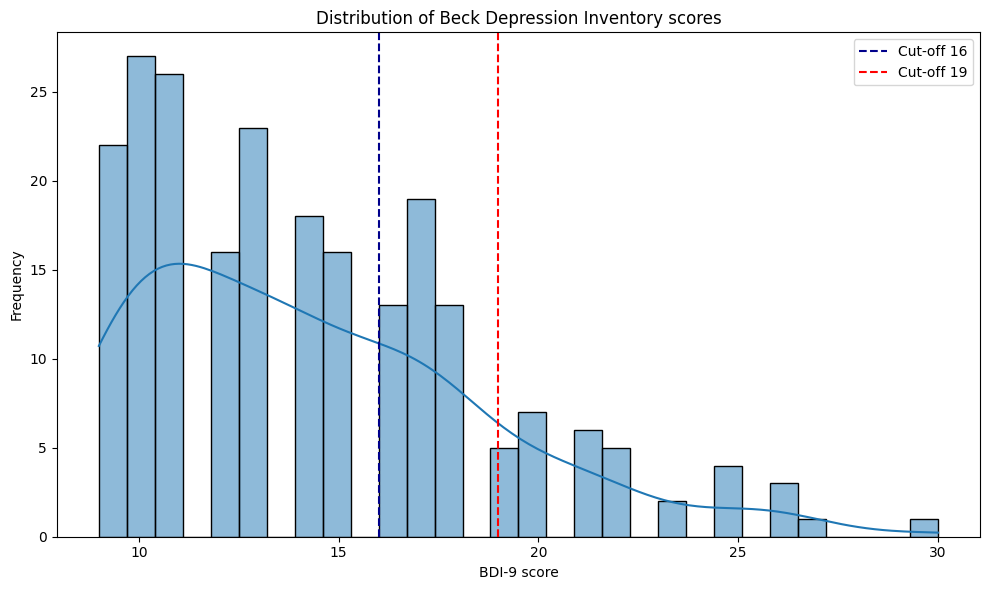

Final sample size after removing missing Beck depression: 227


In [12]:
# ---------------------------------------------------------------------------
# 4 ▸ Feature groups
# ---------------------------------------------------------------------------
# Sentiment‑based predictors aggregated at participant level
emotion_vars = [
    # Negative sentiment distribution
    "Negative_average", "Negative_std",
    "Negative_min", "Negative_q1", "Negative_median", "Negative_q3", "Negative_max",
    # Neutral sentiment distribution
    "Neutral_average",  "Neutral_std",
    "Neutral_min",  "Neutral_q1", "Neutral_median",   "Neutral_q3",   "Neutral_max",
    # Positive sentiment distribution
    "Positive_average", "Positive_std",
    "Positive_min", "Positive_q1", "Positive_median",  "Positive_q3",  "Positive_max",
    # Prompt‑level sentiment dominance ratios
    "Negative_ratio", "Neutral_ratio", "Positive_ratio",
]

# Auxiliary process variables (not analysed in the current manuscript)
other_vars = [
    "total_images", "imagine_bin_ratio", "variation_bin_ratio", "upscale_bin_ratio",
]

# Available questionnaire targets (excerpt)
possible_dependent_vars = [
    # Beck depression
    'Beck depression',
    #Self-esteem and self-image
    'Rosenberg self-esteem', 'Self-Concept Clarity Scale',
    # Big5 personality traits
    'Extraversion/Big5', 'Agreeableness/Big5','Conscientiousness/Big5', 'Neuroticism/Big5', 'Openness/Big5',
    # Ego identity status/ideology
    'Ideological diffusion /Ego Identity Status',
    'Ideological foreclosure/Ego Identity Status',
    'Ideological moratorium/Ego Identity Status',
    'Ideological achieved identity/Ego Identity Status',
    # Ego identity status/interpersonal
    'Interpersonal diffusion/Ego Identity Status',
    'Interpersonal foreclosure/Ego Identity Status',
    'Interpersonal moratorium/Ego Identity Status',
    'Interpersonal achieved identity/Ego Identity Status',
    # Perfectionism
    'Standards/Perfectionism', 'Discrepancy/Perfectionism',
    # Body image
    'Total/Body Image', 'Negative evaluation of body size/Body image',
    'Lack of knowledge about own body/Body image', 'General dissatisfaction with the body/Body image', 'Rest/Body image'
]

dependent_vars = ["Beck depression"]  # The dependent variable used throughout the paper

# ---------------------------------------------------------------------------
# 5 ▸ Derive depression‑risk groupings
# ---------------------------------------------------------------------------
# Two clinically motivated thresholds: ≥16 ⇒ increased risk, ≥19 ⇒ high risk

data["depression_group16"] = (data["Beck depression"] >= 16).astype(int)
data["depression_group19"] = (data["Beck depression"] >= 19).astype(int)

print(data[["Participant_ID", "Beck depression" , "depression_group16", "depression_group19"]].head())
print(" ---------------------------------------------------------------------------")

# ---------------------------------------------------------------------------
# 6 ▸ Quick counts per cut‑off (good sanity‑check for reviewer comments)
# ---------------------------------------------------------------------------
counts_16 = data["depression_group16"].value_counts().to_dict()
counts_19 = data["depression_group19"].value_counts().to_dict()
print("Group-distributions")
print(f"Cut‑off 16 → low {counts_16.get(0,0)}, high {counts_16.get(1,0)}")
print(f"Cut‑off 19 → low {counts_19.get(0,0)}, high {counts_19.get(1,0)}")

# ---------------------------------------------------------------------------
# 7 ▸ Histogram of BDI scores with both thresholds
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(data[dependent_vars], kde=True, bins=30, color="skyblue")
plt.axvline(16, color="darkblue", linestyle="--", label="Cut‑off 16")
plt.axvline(19, color="red",      linestyle="--", label="Cut‑off 19")
plt.title("Distribution of Beck Depression Inventory scores")
plt.xlabel("BDI‑9 score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "BDI_histogram.png", dpi=300)
plt.show()

# ---------------------------------------------------------------------------
# 8 ▸ Cleaned dataset for downstream analysis
# ---------------------------------------------------------------------------
# Drop rows with missing target values to avoid issues in modelling steps.

data = data.dropna(subset=["Beck depression"]).reset_index(drop=True)
print(f"Final sample size after removing missing Beck depression: {len(data)}")

In [ ]:
# ---------------------------------------------------------------------------
# 9. ▸ Examining gender distribution by depression risk groups
# ---------------------------------------------------------------------------

# Step 1 ▸ Create a contingency table (cross-tabulation) of gender by depression group.
# This automatically fills in missing combinations with 0s (e.g., if no males in high-risk group).
ct = pd.crosstab(data['Gender'], data['depression_group16'])

# Step 2 ▸ Check if any expected cell frequency is below 5.
# If yes, Fisher’s exact test is more appropriate (better for small samples).
if (ct.values < 5).any():
    # Fisher’s exact test (only valid for 2×2 tables).
    oddsratio, p_value = st.fisher_exact(ct.values)
    print(f"Fisher’s exact test: odds ratio = {oddsratio:.3f}, p = {p_value:.3f}")
else:
    # If all expected frequencies are ≥ 5, use Chi-square test of independence.
    chi2, p_value, dof, expected = st.chi2_contingency(ct.values)
    print(f"Chi-square test: χ² = {chi2:.3f}, p = {p_value:.3f}")


Chi-square test: χ² = 0.734, p = 0.392


In [ ]:
# ---------------------------------------------------------------------------
# 10. ▸ Statistical power calculation for detectable correlation
# ---------------------------------------------------------------------------

# To assess the minimum effect size (correlation) that can be reliably detected in this study
# given our sample size (N), significance level (alpha), and desired statistical power.

alpha = 0.01        # Significance threshold (type I error rate)
power = 0.8         # Desired statistical power (probability of detecting a real effect)
N = 227          # Sample size

# Calculate z-scores for the given alpha (two-sided test) and power.
z_alpha = st.norm.ppf(1 - alpha/2)   # z value for significance level
z_power = st.norm.ppf(power)         # z value for desired power

# Total z-score required
z_sum = z_alpha + z_power

# Calculate the minimal detectable Pearson correlation coefficient (r_min)
r_min = math.sqrt(z_sum**2 / ((N - 3) + z_sum**2))

print("Minimal detectable correlation (r): {:.3f}".format(r_min))
# Interpretation: Correlations smaller than r_min are unlikely to be detected as statistically significant with this sample size and threshold.


Minimal detectable correlation (r): 0.223


In [ ]:
# ---------------------------------------------------------------------------
# 11. ▸ Functions used in the pipelines
# ---------------------------------------------------------------------------

# --- FUNCTION: Barplot for correlation p-values and effect sizes ---

def plot_results(results_df, group_name="default_group"):
    """
    Plots p-values of correlations as a barplot, colored by correlation direction and scaled by effect size.
    Shows which variables are most strongly and significantly associated with the dependent variable.
    Saves figure with high resolution.
    """
    # Sort results so that least significant (highest p-value) appears last
    sorted_results_df = results_df.sort_values(by='p-value (correlation)', ascending=False)

    plt.figure(figsize=(14, 10))

    # Set bar color: blue for positive correlation, red for negative
    colors = ['blue' if x > 0 else 'red' for x in sorted_results_df['Correlation Coefficient']]
    # Use absolute value of correlation for alpha (bar transparency/intensity)
    color_intensity = np.abs(sorted_results_df['Correlation Coefficient'])
    # Scale alpha (transparency) between 0.25 and 1
    scaled_intensity = np.interp(color_intensity, (color_intensity.min(), color_intensity.max()), (0.25, 1))

    # Draw the bars and add the correlation value as text above each
    for i, (color, alpha) in enumerate(zip(colors, scaled_intensity)):
        var = sorted_results_df.iloc[i]['Independent Variable']
        p_val = sorted_results_df.iloc[i]['p-value (correlation)']
        correlation = sorted_results_df.iloc[i]['Correlation Coefficient']
        plt.bar(i, p_val, color=color, alpha=alpha)
        plt.text(i, p_val, f'{correlation:.2f}', ha='center', va='bottom', fontsize=9)

    plt.xticks(
        ticks=np.arange(len(sorted_results_df)),
        labels=sorted_results_df['Independent Variable'],
        rotation=90
    )
    # Mark commonly used significance thresholds
    plt.axhline(y=0.01, color='red', linestyle='--', label='Significance level 0.01')
    plt.axhline(y=0.05, color='lightcoral', linestyle='--', label='Significance level 0.05')
    plt.title('P-values and Correlation Coefficients')
    plt.xlabel('Variables')
    plt.ylabel('P-value')
    plt.legend()
    plt.tight_layout()

    # Save plot as a high-resolution PNG
    filename = f"p_values_{group_name}.png"
    save_path = os.path.join(OUT_DIR, filename)
    plt.savefig(save_path, format="png", dpi=dpi)
    plt.show()

# --- FUNCTION: Barplot for mean bootstrapped correlations ---

def plot_results_bootstrap(results_df, group_name="default_group"):
    """
    Plots the mean bootstrapped correlation values for each variable.
    Useful for assessing stability and direction of effects under resampling.
    """
    plt.figure(figsize=(14, 10))
    # Sort by mean bootstrapped correlation (descending)
    sorted_results_df = results_df.sort_values(by='Mean bootstrap corr', ascending=False).reset_index(drop=True)
    colors = ['blue' if x > 0 else 'red' for x in sorted_results_df['Mean bootstrap corr']]

    # Barplot for each variable, colored by direction (blue: positive, red: negative)
    for i, (index, row) in enumerate(sorted_results_df.iterrows()):
        plt.bar(i, row['Mean bootstrap corr'], color=colors[i])
        plt.text(i, row['Mean bootstrap corr'], f"{row['Mean bootstrap corr']:.2f}", ha='center', va='bottom', fontsize=9)

    plt.xticks(
        ticks=range(len(sorted_results_df)),
        labels=sorted_results_df['Independent Variable'],
        rotation=90
    )
    plt.xlabel('Variables')
    plt.ylabel('Bootstrap Mean Correlation')
    plt.tight_layout()

    filename = f"bootstrap_corr_{group_name}.png"
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, format="png", dpi=dpi)
    plt.show()

# --- FUNCTION: Bootstrap confidence interval for correlation ---

def bootstrap_correlation(x, y, n_bootstrap=15000, ci=99):
    """
    Computes bootstrap mean and confidence interval for the correlation between two variables.
    Uses Pearson correlation (since you used pearsonr), but can be easily switched to Spearman.
    Returns mean correlation, all bootstrap correlations, lower and upper CI bounds.
    """
    bootstrap_corrs = []
    n = len(x)

    for _ in range(n_bootstrap):
        indices = np.random.choice(range(n), size=n, replace=True)
        sample_x = x[indices]
        sample_y = y[indices]
        corr, _ = pearsonr(sample_x, sample_y)
        if not np.isnan(corr):  # Only add valid correlations (skip if not enough variance in sample)
            bootstrap_corrs.append(corr)

    if not bootstrap_corrs:
        print("Not enough valid data for bootstrapping.")
        return np.nan, [], np.nan, np.nan

    # Calculate confidence interval from bootstrap samples
    lower_bound = np.percentile(bootstrap_corrs, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrap_corrs, 100 - (100 - ci) / 2)

    return np.mean(bootstrap_corrs), bootstrap_corrs, lower_bound, upper_bound

# --- FUNCTION: Scatterplot for variable pair with lowest p-value ---

def plot_lowest_p_value_correlation(results_df, dataframe):
    """
    Finds the variable pair with the lowest p-value in results_df,
    then plots their relationship with a scatterplot and regression line.
    Useful for visualizing the strongest observed effect in your analysis.
    """
    lowest_p_value_row = results_df.loc[results_df['p-érték (korreláció)'].idxmin()]

    x_var = lowest_p_value_row['Független változó']
    y_var = lowest_p_value_row['Függő változó']
    temp_df = dataframe[[x_var, y_var]].dropna()  # Temporary DataFrame with the two variables

    if len(temp_df) < 2:
        print("Not enough data to plot correlation.")
        return

    independent_var_data = temp_df[x_var]
    dependent_var_data = temp_df[y_var]

    # Scatter plot
    sns.scatterplot(x=independent_var_data, y=dependent_var_data)

    # Add linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(independent_var_data, dependent_var_data)
    line_x = np.linspace(independent_var_data.min(), independent_var_data.max(), 100)
    line_y = slope * line_x + intercept
    plt.plot(line_x, line_y, color='red', label=f'Trendline: r={r_value:.2f}, p={p_value:.3f}')

    plt.title(f"Lowest p-value correlation: {x_var} and {y_var}")
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.legend()

    filename = f"scatter_{x_var}_vs_{y_var}.png"
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, format="png", dpi=dpi)
    plt.show()



In [ ]:
# ---------------------------------------------------------------------------
# 12. ▸ Correlation analysis pipeline
# ---------------------------------------------------------------------------

# This block systematically computes correlations between independent and dependent variables,
# visualizes the results, and exports the findings to Excel for further analysis or sharing.

# Group independent variables (currently only 'emotion_vars' used, can be extended)
independent_var_groups = {
    'emotion_vars': emotion_vars,
    # 'other_vars': other_vars  # Uncomment to include other predictors as needed
}

dpi = 1200  # DPI for saving high-resolution figures

results = []  # Collect all results in this list
alpha = 0.01  # Statistical significance threshold (family-wise error rate)

save_folder = OUT_DIR

# --- Main loop: for each dependent variable and each group of predictors ---

for dep_var in dependent_vars:
    print(dep_var)
    for group_name, vars_list in independent_var_groups.items():
        print(group_name)
        group_results = []  # Store the results for this group
        for var in vars_list:
            print(f"Dependent Variable: {dep_var}, Independent Variable: {var}")

            # Remove rows with missing values in either the dependent or independent variable
            cleaned_data = data.dropna(subset=[dep_var, var])

            # Calculate Pearson correlation (assumes interval-level data)
            corr_coefficient, p_value_corr = pearsonr(cleaned_data[dep_var], cleaned_data[var])

            # Print significance information for debugging
            if p_value_corr < alpha:
                print("The correlation is significant.")
            else:
                print("The correlation is not significant.")

            cleaned_data = cleaned_data.reset_index(drop=True)

            # Compute bootstrap confidence intervals for the correlation
            mean_bootstrap_corr, bootstrap_corrs, lower_bound, upper_bound = bootstrap_correlation(
                cleaned_data[dep_var], cleaned_data[var], n_bootstrap=1000, ci=95
            )
            print(f"Bootstrap correlation: {mean_bootstrap_corr}, confidence interval: {lower_bound}, {upper_bound}")

            # --- Visualization: Scatterplot with regression line for each variable pair ---
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=cleaned_data[var], y=cleaned_data[dep_var])
            x = cleaned_data[var]
            y = cleaned_data[dep_var]
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            line_x = np.linspace(x.min(), x.max(), 100)
            line_y = slope * line_x + intercept
            plt.plot(line_x, line_y, color='red', label=f"Trendline: r={r_value:.2f}, p={p_value:.3f}")
            plt.title(f"Correlation: {var} and {dep_var}")
            plt.xlabel(var)
            plt.ylabel(f"{dep_var} score")
            plt.legend()
            filename = f"scatter_{var}_vs_{dep_var}.png"
            save_path = os.path.join(OUT_DIR, filename)
            plt.savefig(save_path, format="png", dpi=dpi)
            plt.show()

            # Print numeric results for transparency
            print(f"Pearson correlation coefficient: {corr_coefficient}")
            print(f"p-value: {p_value_corr}")

            # Store all results (including CI and bootstrap values) for further use and reproducibility
            group_results.append({
                "Dependent Variable": dep_var,
                "Independent Variable": var,
                "Independent Variable Group": group_name,
                "Correlation Coefficient": corr_coefficient,
                "p-value (correlation)": p_value_corr,
                "Mean bootstrap corr": mean_bootstrap_corr,
                "bootstrap_corrs": bootstrap_corrs,
                "lower bound": lower_bound,
                "upper bound": upper_bound
            })

        # --- Group-level visualization: Barplots for all variables in this group ---
        group_results_df = pd.DataFrame(group_results)
        plot_results(group_results_df, group_name=group_name)
        plot_results_bootstrap(group_results_df, group_name=group_name)

        # Aggregate group results to total results list
        results.extend(group_results)

# --- Collect all results into a DataFrame for easier sorting, reporting, and exporting ---
results_df = pd.DataFrame(results)

# --- Save all results to Excel for open science and easy reviewer access ---

save_folder = "/content/drive/My Drive/Nature cikkhez ábrák 2025"
os.makedirs(save_folder, exist_ok=True)  # Make sure the folder exists

excel_filename = "correlation_results_df.xlsx"
excel_path = os.path.join(save_folder, excel_filename)

results_df.to_excel(excel_path, index=False)

print(f"Results saved to: {excel_path}")



In [ ]:
# ---------------------------------------------------------------------------
# 12. ▸ Group comparison pipeline
# ---------------------------------------------------------------------------

# This script compares each independent variable between high-risk and low-risk depression groups,
# using two binary grouping criteria (cutoffs at 16 and 19 on the Beck scale), and visualizes all results.

# Define binary dependent variables for grouping (Beck cutoffs 16 and 19)
binary_vars = ['depression_group16', 'depression_group19']

results = []         # Collect all t-test results here
alpha = 0.01         # Statistical significance threshold

# For each binary group variable (16/19 cutoffs), test all predictors (emotion_vars)
for bin_var in binary_vars:
    for group_name, vars_list in independent_var_groups.items():
        group_results = []
        for var in vars_list:
            print(f"Dependent Variable: {bin_var}, Independent Variable: {var}")

            # Remove missing values for the current variables
            cleaned_data = data.dropna(subset=[bin_var, var])

            # Define high and low risk groups for the current binary split
            if bin_var in cleaned_data.columns:
                group1 = cleaned_data[cleaned_data[bin_var] == 1][var]  # High risk
                group0 = cleaned_data[cleaned_data[bin_var] == 0][var]  # Low risk
                # Only test if both groups have at least two samples
                if len(group1) > 1 and len(group0) > 1:
                    t_stat, p_value_ttest = ttest_ind(group1, group0)
                else:
                    t_stat, p_value_ttest = np.nan, np.nan
            else:
                t_stat, p_value_ttest = np.nan, np.nan

            print("t-statistics:", t_stat)
            print("p-value (t-test):", p_value_ttest)

            # Mark significance (debug output, can be commented out)
            if p_value_ttest < alpha:
                print("The t-test is significant.")
            else:
                print("The t-test is not significant.")

            # --- Boxplot: Visualize group differences for each variable ---
            plt.figure(figsize=(10, 6), dpi=dpi)
            box = sns.boxplot(x=bin_var, y=var, data=cleaned_data, color='white', linewidth=2.5)

            # Make boxes more visible: thicker black edges for publication-level clarity
            for i, artist in enumerate(box.artists):
                artist.set_edgecolor('black')
                for j in range(i*6, i*6+6):  # Each box has 6 associated lines (whiskers etc.)
                    line = box.lines[j]
                    line.set_color('black')
                    line.set_mfc('black')
                    line.set_mec('black')
                    line.set_linewidth(5)

            plt.title(f'Group Differences: {var}', fontsize=14, fontweight='bold')
            plt.xlabel(bin_var, fontsize=12)
            plt.ylabel(var, fontsize=12)
            plt.show()

            # Store t-test results for later analysis and exporting
            group_results.append({
                'Independent Variable': var,
                'Binary Variable': bin_var,
                't-statistics': t_stat,
                'p-value (t-test)': p_value_ttest
            })

        # --- Summary plot for all variables in this group (barplot of p-values, t-values as text) ---
        group_results_df = pd.DataFrame(group_results)
        plt.figure(figsize=(14, 10), dpi=dpi)
        sorted_results_df = group_results_df.sort_values(by='p-value (t-test)', ascending=False).reset_index(drop=True)
        colors = ['blue' if x > 0 else 'red' for x in sorted_results_df['t-statistics']]
        color_intensity = np.interp(sorted_results_df['t-statistics'].abs(),
                                    (sorted_results_df['t-statistics'].abs().min(),
                                     sorted_results_df['t-statistics'].abs().max()),
                                    (0.25, 1))
        for i, (p_val, t_stat_value) in enumerate(zip(sorted_results_df['p-value (t-test)'], sorted_results_df['t-statistics'])):
            plt.bar(i, p_val, color=colors[i], alpha=color_intensity[i])
            plt.text(i, p_val, f'{t_stat_value:.2f}', ha='center', va='bottom', fontsize=9)
        plt.xticks(ticks=range(len(sorted_results_df)), labels=sorted_results_df['Independent Variable'], rotation=90)
        plt.axhline(y=0.01, color='red', linestyle='--', label='Significance Level 0.01')
        plt.axhline(y=0.05, color='lightcoral', linestyle='--', label='Significance Level 0.05')
        plt.title(f"P-values and T-test Results: {bin_var}")
        plt.xlabel('Variables')
        plt.ylabel('p-value')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Collect all group results
        results.extend(group_results)

# Save all results to Excel for transparency and reproducibility
save_folder = "/content/drive/My Drive/Nature cikkhez ábrák 2025"
os.makedirs(save_folder, exist_ok=True)

excel_filename = "binary16_19_results_df.xlsx"
excel_path = os.path.join(save_folder, excel_filename)

results_df = pd.DataFrame(results)
results_df.to_excel(excel_path, index=False)

print(f"Results saved to: {excel_path}")


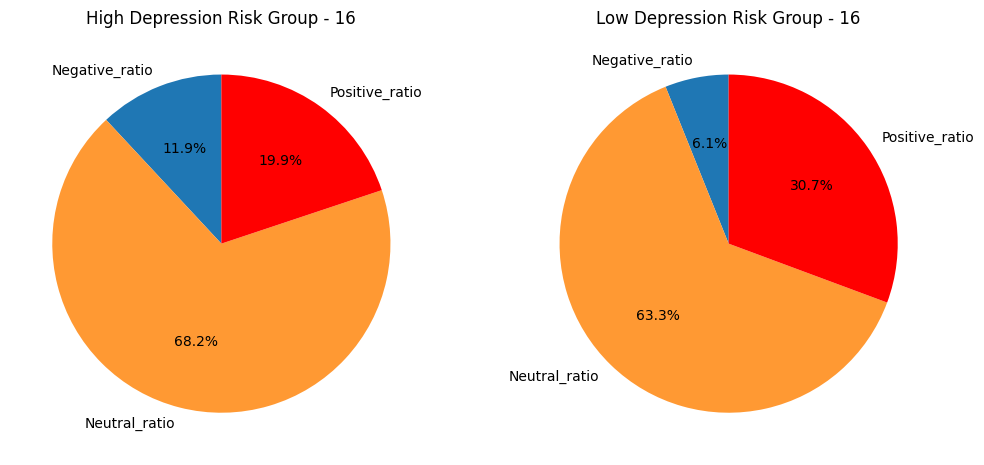

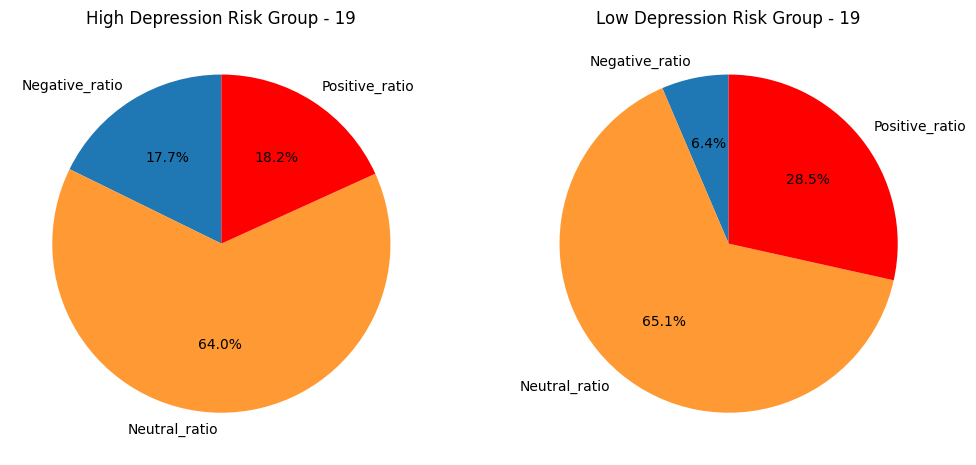

In [ ]:
# ---------------------------------------------------------------------------
# 13. ▸ Pie charts - sentiment distribution ratio
# ---------------------------------------------------------------------------

# This code block compares the average ratios of negative, neutral, and positive prompt sentiments
# between participants at high and low risk of depression, visualized using pie charts for each group.

# ---- First: Using cutoff at 16 on Beck depression scale ----

# Filter the data for depressed (high risk) and non-depressed (low risk) groups
depressed_group = data[data['depression_group16'] == 1]
non_depressed_group = data[data['depression_group16'] == 0]

# Calculate mean ratios for each sentiment type in both groups
depressed_ratios = depressed_group[['Negative_ratio', 'Neutral_ratio', 'Positive_ratio']].mean()
non_depressed_ratios = non_depressed_group[['Negative_ratio', 'Neutral_ratio', 'Positive_ratio']].mean()

# Prepare side-by-side pie charts for easy visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Define colors for the pie segments: blue for negative, orange for neutral, red for positive
colors = ['#1f77b4', '#ff9933', '#ff0000']

# Pie chart for non-depressed (low-risk) group
ax2.pie(
    non_depressed_ratios,
    labels=non_depressed_ratios.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax2.set_title('Low Depression Risk Group - 16')

# Pie chart for depressed (high-risk) group
ax1.pie(
    depressed_ratios,
    labels=depressed_ratios.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax1.set_title('High Depression Risk Group - 16')

# Display the charts
plt.show()

# ---- Second: Repeat using cutoff at 19 on Beck depression scale ----

# Filter for high- and low-risk groups using the 19-point cutoff
depressed_group = data[data['depression_group19'] == 1]
non_depressed_group = data[data['depression_group19'] == 0]

# Calculate mean ratios for each sentiment type again
depressed_ratios = depressed_group[['Negative_ratio', 'Neutral_ratio', 'Positive_ratio']].mean()
non_depressed_ratios = non_depressed_group[['Negative_ratio', 'Neutral_ratio', 'Positive_ratio']].mean()

# Create side-by-side pie charts again for the 19 cutoff
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Use the same color scheme for consistency
colors = ['#1f77b4', '#ff9933', '#ff0000']

# Pie chart for non-depressed (low-risk) group (cutoff 19)
ax2.pie(
    non_depressed_ratios,
    labels=non_depressed_ratios.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax2.set_title('Low Depression Risk Group - 19')

# Pie chart for depressed (high-risk) group (cutoff 19)
ax1.pie(
    depressed_ratios,
    labels=depressed_ratios.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax1.set_title('High Depression Risk Group - 19')

# Display the final charts
plt.show()


Dropping 'Positive_average' (VIF=139.14)
Dropping 'Negative_average' (VIF=115.82)
Dropping 'Negative_std' (VIF=35.08)
Dropping 'Positive_std' (VIF=21.05)
Dropping 'Positive_ratio' (VIF=10.21)
Dropping 'Negative_ratio' (VIF=8.07)
Dropping 'Positive_median' (VIF=6.31)
Final predictors after VIF filtering:
            feature        VIF
0            const  24.270126
1     Negative_min   2.200095
2      Negative_q1   3.037908
3  Negative_median   2.727190
4      Negative_q3   3.202304
5     Negative_max   2.233552
6     Positive_min   2.837830
7      Positive_q1   3.689725
8      Positive_q3   2.646302
9     Positive_max   2.336504


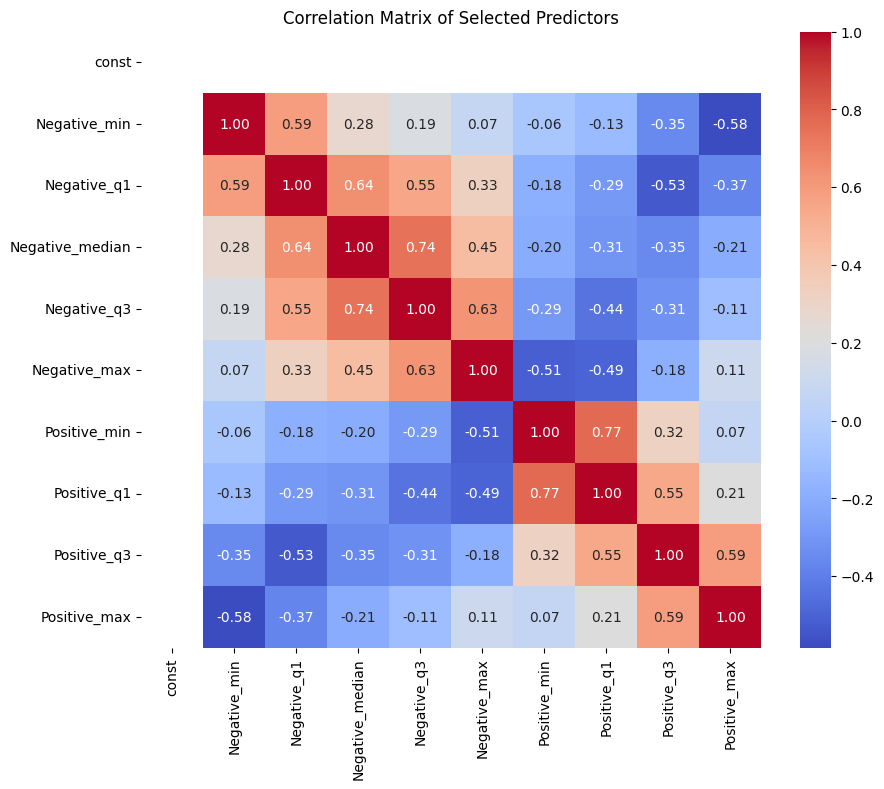

                            OLS Regression Results                            
Dep. Variable:        Beck depression   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     5.935
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.05e-07
Time:                        21:09:02   Log-Likelihood:                -628.80
No. Observations:                 227   AIC:                             1278.
Df Residuals:                     217   BIC:                             1312.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.2590      1.291     

In [ ]:
# ------------------------------------------------------------------------------
# 14. ▸ VIF analysis and OLS regression
# ------------------------------------------------------------------------------

import pandas as pd
import numpy as np
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Step 1: Define predictor set and outcome variable ---
# These predictors were selected based on prior significance or theoretical relevance.
sig_vars = [
    "Negative_average", "Negative_std", "Positive_average", "Positive_std",
    "Negative_ratio", "Positive_ratio",
    "Negative_min", "Negative_q1", "Negative_median", "Negative_q3", "Negative_max",
    "Positive_min", "Positive_q1", "Positive_median", "Positive_q3", "Positive_max"
]

# Target variable: Beck Depression Inventory score
target_var = 'Beck depression'

# --- Step 2: Create design matrix with intercept ---
# Add constant term for the intercept in OLS regression
X = data[sig_vars].copy()
X = add_constant(X)
y = data[target_var]  # Target variable as Series

# --- Step 3: Iterative Variance Inflation Factor (VIF) filtering ---
# This function removes predictors one-by-one if their VIF > 5 (indicating multicollinearity).
# The loop stops when all remaining predictors have VIF below the threshold.
def reduce_vif(X, thresh=5.0):
    variables = list(X.columns)
    while True:
        # Compute VIF for each variable
        vif = pd.Series(
            [variance_inflation_factor(X[variables].values, i)
             for i in range(len(variables))],
            index=variables
        )
        # Ignore the intercept in VIF filtering
        vif_no_const = vif.drop('const', errors='ignore')
        max_vif = vif_no_const.max()
        if max_vif > thresh:
            drop_var = vif_no_const.idxmax()
            print(f"Dropping '{drop_var}' (VIF={max_vif:.2f})")
            variables.remove(drop_var)
        else:
            break
    return X[variables]

# Run the VIF filter to remove problematic predictors
X_vif = reduce_vif(X, thresh=5.0)

# --- Step 4: Show final VIF values after filtering ---
vif_final = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("Final predictors after VIF filtering:\n", vif_final)

# --- Step 5: Visualize correlation matrix of retained predictors ---
# This helps confirm that remaining variables are not highly correlated.
plt.figure(figsize=(10, 8))
sns.heatmap(X_vif.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Predictors')
plt.show()

# --- Step 6: Fit OLS regression model using statsmodels ---
model = OLS(y, X_vif).fit()
print(model.summary())  # Includes coefficients, t-values, R², and more

# --- Step 7: Model diagnostics ---
# These tests assess assumptions of linear regression: normality and homoscedasticity.

# Omnibus test for normality of residuals (based on skewness and kurtosis)
omni_stat, omni_p = omni_normtest(model.resid)
print(f"Omnibus: stat={omni_stat:.3f}, p={omni_p:.3f}")

# Jarque–Bera test for normality (a more specific test)
jb_stat, jb_p, _, _ = jarque_bera(model.resid)
print(f"Jarque–Bera: stat={jb_stat:.3f}, p={jb_p:.3f}")

# Breusch–Pagan test for heteroscedasticity (non-constant variance of residuals)
bp_stat, bp_p, _, _ = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch–Pagan: stat={bp_stat:.3f}, p={bp_p:.3f}")
if bp_p < 0.05:
    print("Heteroscedasticity detected.")  # Assumption violated
else:
    print("No significant heteroscedasticity.")  # Assumption holds


In [ ]:
# ------------------------------------------------------------------------------
# 15. ▸ Generalized Linear Modelling
# ------------------------------------------------------------------------------

# Selecting the independent variables (predictors) that were previously retained
# after VIF filtering due to multicollinearity issues.
X = data[[
    'Negative_min', 'Negative_q1', 'Negative_median', 'Negative_q3', 'Negative_max',
    'Positive_min', 'Positive_q1', 'Positive_q3', 'Positive_max',
]]

# Defining the dependent variable: Beck Depression score
y = data['Beck depression']

# --- Standardizing predictors ---
# Standardization helps interpret model coefficients on a comparable scale.
# This is especially useful in GLMs and when assessing variable importance.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Adding a constant (intercept) term manually after scaling.
# Note: scaling removes the mean, so this intercept restores the baseline level.
X_scaled = sm.add_constant(X_scaled)

# --- Specifying the GLM model ---
# GLM with Gaussian family and identity link, which is equivalent to linear regression.
# It allows for flexible inference with robust standard errors (see below).
glm_model = sm.GLM(y, X_scaled, family=sm.families.Gaussian())

# --- Defining initial parameter values ---
# Start with all regression coefficients set to zero (helps model convergence).
start_params = np.zeros(X_scaled.shape[1])

# --- Fitting the model ---
# HC0 = White’s robust covariance estimator for heteroskedasticity-consistent standard errors.
# This makes the inference more reliable when residuals have non-constant variance.
glm_results = glm_model.fit(start_params=start_params, cov_type='HC0')

# Displaying the regression summary (coefficients, standard errors, significance, etc.)
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:        Beck depression   No. Observations:                  227
Model:                            GLM   Df Residuals:                      217
Model Family:                Gaussian   Df Model:                            9
Link Function:               Identity   Scale:                          15.600
Method:                          IRLS   Log-Likelihood:                -628.80
Date:                Mon, 02 Jun 2025   Deviance:                       3385.3
Time:                        21:10:07   Pearson chi2:                 3.39e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2105
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3348      0.256     55.927      0.0

In [3]:
"""
# ------------------------------------------------------------------------------
# 16. ▸ Machine-Learning Classification Pipeline
# ------------------------------------------------------------------------------

This script implements a full analysis pipeline for predicting depression risk-group
using machine. It is organized as follows:

    - Define the sentiment-derived feature set (e.g., Negative_min, Negative_q1, …, Positive_max).
    - Load the same dataset and build X (features) & y (binary labels) based on the BDI cutoff (≥16).
    - Standardize features and perform a 2-component principal component analysis (PCA) for visualization.
    - Set up a StratifiedKFold cross-validation scheme (n_splits=10) with a fixed random state for reproducibility.
    - Define a dictionary of sampling strategies (None, SMOTE, SMOTETomek, SMOTEENN) to correct class imbalance during training.
    - Specify a collection of classifiers and their hyperparameter grids:
        • Logistic Regression
        • Support Vector Machine (SVM)
        • RidgeClassifier
        • Stochastic Gradient Descent (SGDClassifier)
        • Gaussian Naive Bayes
        • K-Nearest Neighbors
        • RandomForestClassifier (shallow trees)
        • BalancedRandomForestClassifier
    - For each (sampler, classifier) combination:
        a) Build an imblearn Pipeline:
               [ (StandardScaler ?), (Sampler), (Classifier) ]
            – Note: For GaussianNB, RandomForest, and BalancedRandomForest, we skip scaling
              because these models do not strictly require standardized inputs.
            – Sampler=”passthrough” if no oversampling is used.
        b) Use GridSearchCV (with 10-fold StratifiedKFold, ROC-AUC as the scoring metric) to find the best hyperparameters.
        c) After fitting, extract cross-validated probability scores (or decision_function outputs) via cross_val_predict.
        d) Compute default-threshold (0.5) metrics: accuracy, precision, recall, balanced accuracy, MCC.
        e) Execute a custom “manual_cross_val_auc” routine to compute pointwise AUC fold by fold, avoiding NaNs when a test fold contains only one class.
        f) Find an “optimal threshold” between [0.3, 0.7] that maximizes F1, using precision-recall curves (function: find_best_threshold_from_scores).
        g) Plot and save confusion matrices:
              1) At the default threshold (0.5)
              2) At the optimal threshold
              3) A normalized (row-wise) heatmap for the optimal threshold
        h) If the chosen classifier exposes a `coef_` attribute (i.e., linear models), project its decision boundary into PCA space:
              • Compute w_pca = coef · (PCA components)^T
              • Generate a 2D mesh grid spanning the first two principal components
              • Compute predicted probabilities over the grid via the logistic sigmoid
              • Draw the contour at the optimized threshold
              • Overlay the PCA‐transformed data points, colored by true label
        i) Store per-combination results (best params, feature importances or coefficients,
           optimal threshold, cross-val AUC mean±std, default-threshold metrics,
           optimal-threshold metrics) into a Python list of dictionaries.
        j) Periodically save partial results to “partial_results.csv” in the output folder
           so that long-running jobs can be resumed or inspected.

     - After looping over all (sampler, model) pairs, consolidate the results into a pandas
      DataFrame with a consistent column order, and save it as a final CSV
      (e.g., “linear_classifier_metrics_final_kétségbeesés16.csv”).

Throughout the pipeline:
  • We carefully encapsulate oversampling (SMOTE, SMOTETomek, SMOTEENN) within the cross-validation
    pipeline to avoid any data leakage.
  • We use ROC-AUC as a primary metric in hyperparameter tuning (grid_search), since it is threshold-independent.
  • Post-hoc, we optimize a threshold for F1 to mitigate class imbalance and emphasize
    a trade-off between precision and recall.
  • We also record standard deviations of cross-validation metrics to reflect modeling variability.
  • All figures are saved at high resolution (dpi=1200) in a designated folder for publication purposes.

The overall goal is to demonstrate that interpretable, sentiment-based features—extracted via RoBERTa sentiment analysis—can capture meaningful signals related to depression risk, and to compare multiple classifiers under different oversampling strategies. Although no classifier is perfect, this pipeline ensures rigorous cross-validation, transparent threshold tuning, and comprehensive reporting of both statistical and machine-learning results.
"""


import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import OLS, add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import norm  # used implicitly in power calculation
from tqdm.auto import tqdm

from google.colab import drive  # only if running in Colab

# Imbalanced‐learning pipeline components
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# Scikit‐learn model‐selection, preprocessing, metrics, and classifiers
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, cross_validate
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    balanced_accuracy_score,
    matthews_corrcoef,
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    make_scorer
)


In [4]:
def find_best_threshold_from_scores(scores, y, thr_min=0.3, thr_max=0.7):
    """
    Given a 1D array of model scores (probabilities or margins) and true binary labels y,
    compute precision‐recall curve, then search for the threshold within [thr_min, thr_max]
    that maximizes F1. If no threshold falls in that window, return (0.5, 0.0, 0.0).
    Returns:
      (best_threshold, best_f1, corresponding_recall)
    scores: a 1D array of prediction scores (can be probabilities or decision margins)
    y: true binary labels
    The function finds the threshold in a given interval that maximizes F1 score.
    """
    prec, rec, thr = precision_recall_curve(y, scores)
    f1s_thr = 2 * prec[1:] * rec[1:] / (prec[1:] + rec[1:] + 1e-9)  # F1 scores for each threshold

    # If scores are between 0 and 1, we filter the thresholds between given limits
    if scores.min() >= 0 and scores.max() <= 1:
        mask = (thr >= thr_min) & (thr <= thr_max)
    else:
        # If scores are not in [0, 1] (e.g., decision_function), use all thresholds
        mask = np.ones_like(thr, dtype=bool)

    if mask.any():
        idx = np.argmax(f1s_thr[mask])
        return thr[mask][idx], f1s_thr[mask][idx], rec[1:][mask][idx]  # threshold, best F1, recall
    else:
        return 0.5, 0.0, 0.0  # fallback if no thresholds fall in range

def plot_confusion_matrices_with_opt_threshold(
    y_true, proba_cv, threshold_opt,
    sampler_name, model_name, output_folder,
    best_estimator, pca, X_pca, scaler, X, y
):
    """
    1) Plot and save a confusion matrix using the default threshold (0.5).
    2) Plot and save a confusion matrix using the optimized threshold `threshold_opt`.
    3) Plot and save the normalized confusion matrix heatmap.
    4) If the classifier has a coef_ attribute, project its decision boundary onto the first two PCA components:
       - Compute w_pca = coef · (PCA components)^T
       - Build a meshgrid in PCA space, compute predicted probabilities via sigmoid(Z) = 1/(1 + exp(−Z))
       - Draw the contour at level = threshold_opt
       - Scatter‐plot the PCA‐transformed data points colored by true label.
    Returns: (accuracy_at_opt, precision_at_opt, balanced_accuracy_at_opt, mcc_at_opt)
    """
    # 1. Confusion matrix using fixed threshold = 0.5
    pred_default = (proba_cv >= 0.5).astype(int)
    cm_default = confusion_matrix(y_true, pred_default)
    disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default)
    disp_default.plot(cmap="Blues")
    plt.title(f"CM @ 0.5: {sampler_name} + {model_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"cm_default_{sampler_name}_{model_name}.png"))
    plt.show()

    # 2. Confusion matrix using optimal threshold found earlier
    pred_opt = (proba_cv >= threshold_opt).astype(int)
    cm_opt = confusion_matrix(y_true, pred_opt)
    disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt)
    disp_opt.plot(cmap="Blues")
    plt.title(f"CM @ Opt {threshold_opt:.3f}: {sampler_name} + {model_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"cm_opt_{sampler_name}_{model_name}.png"))
    plt.show()

    # 3. Normalized confusion matrix as heatmap
    # This helps visualize relative proportions instead of absolute values
    cm_norm = cm_opt.astype(float) / cm_opt.sum(axis=1)[:, None]
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.title("Normalized confusion matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"cm_norm_{sampler_name}_{model_name}.png"))
    plt.show()

    # --- PCA-based decision boundary visualization ---
    classifier = best_estimator.named_steps["clf"]
    if hasattr(classifier, "coef_"):
        # Retrieve model coefficients (assumed linear model)
        coef = np.asarray(classifier.coef_[0])

        # Extract intercept
        intercept_val = classifier.intercept_
        b = float(intercept_val[0]) if isinstance(intercept_val, np.ndarray) else float(intercept_val)

        # Project weights into PCA space
        if coef.ndim == 1:
             w_pca = coef.dot(pca.components_.T)
        elif coef.ndim == 2 and coef.shape[0] == 1:
             w_pca = coef[0].dot(pca.components_.T)
        else:
             print(f"Warning: Unexpected shape for coef_: {coef.shape} for model {model_name}. Skipping PCA boundary plot.")
             w_pca = None  # indicates skip

        # Plot decision boundary if projection is available
        if w_pca is not None:
            xx, yy = np.meshgrid(
                np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 200),
                np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 200)
            )
            Z = w_pca[0] * xx + w_pca[1] * yy + b
            proba_grid = 1 / (1 + np.exp(-Z))  # Apply sigmoid to get probability surface

            plt.figure(figsize=(6,5))
            plt.contourf(xx, yy, proba_grid, levels=20, cmap="RdBu", alpha=0.4)
            plt.contour(xx, yy, proba_grid, levels=[threshold_opt], colors="k", linestyles="--")
            sns.scatterplot(
                x=X_pca[:,0], y=X_pca[:,1], hue=y,
                palette="Set1", edgecolor="k", alpha=0.7
            )
            plt.xlabel("PC1"); plt.ylabel("PC2")
            plt.title(f"PCA + Decision boundary (@{threshold_opt:.2f})\n{sampler_name} + {model_name}")
            plt.legend(title="Depression")
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f"pca_boundary_{sampler_name}_{model_name}.png"))
            plt.show()
    else:
        print(f"Warning: Classifier {model_name} does not have a 'coef_' attribute. Skipping PCA boundary plot.")


    # --- Return classification metrics using optimal threshold ---
    acc_opt = accuracy_score(y_true, pred_opt)
    prec_opt = precision_score(y_true, pred_opt)
    balacc_opt = balanced_accuracy_score(y_true, pred_opt)
    mcc_opt = matthews_corrcoef(y_true, pred_opt)
    return acc_opt, prec_opt, balacc_opt, mcc_opt

def get_scores(estimator, X, y, cv):
    """
    Performs cross‐validated score retrieval:
      - If `estimator` supports predict_proba, return cross_val_predict(..., method="predict_proba")[:, 1]
      - Else if it supports decision_function, return cross_val_predict(..., method="decision_function")
      - Otherwise, fall back to cross_val_predict(..., method="predict") returning {0,1} predictions.
    """
    # If the model has a predict_proba method (e.g., LogisticRegression), use it
    if hasattr(estimator, "predict_proba"):
        return cross_val_predict(estimator, X, y, cv=cv, method="predict_proba")[:,1]
    # Otherwise, if it has a decision_function (e.g., SVM), use that
    if hasattr(estimator, "decision_function"):
        return cross_val_predict(estimator, X, y, cv=cv, method="decision_function")
    # Fallback: use hard predictions (0 or 1)
    return cross_val_predict(estimator, X, y, cv=cv, method="predict")


def manual_cross_val_auc(estimator, X, y, cv):
    """
    Performs manual fold‐by‐fold AUC calculation to avoid NaNs due to single‐class test folds:
      - For each split in cv.split(X, y):
          • Fit a fresh clone(estimator) on train indices
          • Use predict_proba (or decision_function) on test indices to get scores
          • If the test split contains fewer than 2 unique labels, skip it
          • Otherwise, compute roc_auc_score
      - Return (mean_auc, std_auc)
    """
    aucs = []  # will store AUC scores for each fold
    for train_idx, test_idx in cv.split(X, y):
        est = clone(estimator)  # create a new, untrained copy of the model
        est.fit(X[train_idx], y[train_idx])  # train on training data
        if hasattr(est, "predict_proba"):
            scores = est.predict_proba(X[test_idx])[:,1]  # use probability if available
        else:
            scores = est.decision_function(X[test_idx])  # fallback to margin values
        # skip fold if the test set contains only one class
        if len(np.unique(y[test_idx])) < 2:
            continue
        aucs.append(roc_auc_score(y[test_idx], scores))  # compute AUC for this fold
    return np.mean(aucs), np.std(aucs)  # return mean and std of AUC scores





In [5]:
# ─── Sentiment‐based predictor names ──────────────────────────
sig_vars = [
    'Negative_min', 'Negative_q1', 'Negative_median', 'Negative_q3', 'Negative_max',
    'Positive_min', 'Positive_q1', 'Positive_q3', 'Positive_max',
]

# ─── File paths / configuration ────────────────────────────
DATA_PATH = Path("/content/drive/My Drive/összes_szakdogaprompt_aggregált_Nature.csv")
OUTPUT_FOLDER = Path("/content/drive/My Drive/Nature cikkhez ábrák 2025")

df_res = None       # Will be assigned at the end to pd.DataFrame(results)
df_file_name = "linear_classifier_metrics_16.csv"

# ─── Modeling hyperparameters ─────────────────────────────
CUTOFF = 16            # Beck threshold for “high‐risk”
RANDOM_STATE = 567     # Seed for reproducibility
n_splits = 10          # Number of folds for StratifiedKFold

# ─── Data loading & feature/label setup ────────────────────
data = pd.read_csv(DATA_PATH)
X = data[sig_vars]                               # feature matrix of selected sentiment vars
y = (data['Beck depression'] >= CUTOFF).astype(int)  # binary target: 1 if Beck ≥ CUTOFF, else 0

feature_names = list(X.columns)  # list of column names in X

# ─── Preprocessing: scaling + PCA projection ──────────────
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# ─── Cross‐validation setup ───────────────────────────────
cv = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE, shuffle=True)

# ─── AUC scoring for GridSearchCV ────────────────────────
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# ─── Sampling methods dictionary ──────────────────────────
samplers = {
    "None": None,
    "SMOTE": SMOTE(random_state=RANDOM_STATE),
    "SMOTETomek": SMOTETomek(random_state=RANDOM_STATE),
    "SMOTEENN": SMOTEENN(random_state=RANDOM_STATE),
}

# ─── Classifiers and their hyperparameter grids ────────────
models_and_grids = {
    "LogisticRegression": {
        "model": LogisticRegression(random_state=RANDOM_STATE),
        "grid": {
            "clf__solver": ["liblinear", "lbfgs"],
            "clf__C": [0.001, 0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"]
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=RANDOM_STATE),
        "grid": {
            "clf__C": [0.1, 1, 10],
            "clf__kernel": ["linear", "rbf"],
        }
    },
    "RidgeClassifier": {
        "model": RidgeClassifier(random_state=RANDOM_STATE),
        "grid": {
            "clf__alpha": [0.1, 1.0, 10.0],
            "clf__fit_intercept": [True, False],
        }
    },
    "SGDClassifier": {
        "model": SGDClassifier(loss="log_loss", random_state=RANDOM_STATE),
        "grid": {
            "clf__alpha": [0.0001, 0.001, 0.01],
            "clf__penalty": ["l2", "l1", "elasticnet"],
            "clf__max_iter": [1000, 2000],
        }
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "grid": {}  # no hyperparameters to tune
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "grid": {
            "clf__n_neighbors": [5, 7, 9],
            "clf__weights": ["uniform", "distance"]
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        "grid": {
            "clf__n_estimators": [30, 50],
            "clf__max_depth": [2, 3, 4],
            "clf__min_samples_leaf": [10, 15],
            "clf__min_samples_split": [20, 30],
        }
    },
    "BalancedRandomForest": {
        "model": BalancedRandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        "grid": {
            "clf__n_estimators": [50, 100],
            "clf__max_depth": [None, 5, 10]
        }
    },
}


# ─── Container for accumulating per‐model results ─────────
results = []

# ─── Scoring dictionary for cross_validate ────────────────
scoring = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score),
    "roc_auc": make_scorer(roc_auc_score, needs_proba=True),
    "accuracy": make_scorer(accuracy_score),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "matthews_corrcoef": make_scorer(matthews_corrcoef),
}

# ─── Final output table column ordering ──────────────────
final_columns = [
    "Sampler", "Model", "Best Params", "Feature Importances",
    "AUC_cv_mean", "AUC_cv_std",
    "Accuracy_cv_mean", "Accuracy_cv_std",
    "Balanced_Accuracy_cv_mean", "Balanced_Accuracy_cv_std",
    "Recall_cv_mean", "Recall_cv_std",
    "Precision_cv_mean", "Precision_cv_std",
    "F1_cv_mean", "F1_cv_std",
    "MCC_cv_mean", "MCC_cv_std",
    "Optimal_Threshold",
    "AUC_opt",
    "Accuracy_opt",
    "Balanced_Accuracy_opt",
    "Recall_opt",
    "Precision_opt",
    "F1_opt",
    "MCC_opt"
]




In [ ]:
# --- Loop through all samplers and models ---
# Outer loop: go over each sampling method (e.g., SMOTE)
for sampler_name, sampler in tqdm(samplers.items(), desc="Samplers"):
    # Inner loop: go over all models and their grid definitions
    for model_name, mg in tqdm(models_and_grids.items(), desc=f"Models for {sampler_name}", leave=False):
        print(f"\n--- {sampler_name} + {model_name} ---")
                # Assemble the steps of the pipeline
        # GaussianNB, RandomForest and BalancedRF don't need scaling
        if model_name in ["GaussianNB", "RandomForestClassifier", "BalancedRandomForest" ]:
            steps = []  # no scaler step needed
        else:
            steps = [("scaler", StandardScaler())]  # apply standardization first

        # Add the sampler step (SMOTE, SMOTEENN, etc.), or passthrough if none
        if sampler is not None:
            steps.append(("sampler", sampler))
        else:
            steps.append(("sampler", "passthrough"))

        # Add the classifier as the final step
        steps.append(("clf", mg["model"]))
        pipeline = Pipeline(steps)  # create the imblearn pipeline object

        # Define the grid search with cross-validation
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=mg["grid"],      # model-specific hyperparameter grid
            scoring='roc_auc',          # optimize AUC during search
            refit=True,                 # refit the best model after CV
            cv=cv,                      # use predefined cross-validator
            n_jobs=-1,                  # use all CPU cores
            verbose=1,                  # show progress output
        )

        # Fit model and perform hyperparameter search
        grid_search.fit(X, y)
        best = grid_search.best_estimator_  # best model after search

        # --- STEP 1: Get CV prediction scores from the best model ---
        # If predict_proba exists: use probability of class 1
        # Else if decision_function exists: use margin values
        scores_cv = get_scores(estimator=best, X=X, y=y, cv=cv)

        # --- STEP 2: Predict labels from scores using 0.5 threshold for probability ---
        # or 0 threshold for margin (depending on model)
        if hasattr(best.named_steps["clf"], "predict_proba"):
            pred_cv = (scores_cv >= 0.5).astype(int)
        else:
            pred_cv = (scores_cv >= 0).astype(int)

        cv_res = grid_search.cv_results_  # raw CV output
        # Calculate various standard classification metrics on the CV predictions
        cv_acc   = accuracy_score(y, pred_cv)
        cv_prec  = precision_score(y, pred_cv)
        cv_rec   = recall_score(y, pred_cv)
        cv_f1    = f1_score(y, pred_cv)
        cv_auc   = roc_auc_score(y, scores_cv)
        cv_bal_acc   = balanced_accuracy_score(y, pred_cv)
        cv_mcc       = matthews_corrcoef(y, pred_cv)

        # 1) Use cross_validate to get per-fold scores and their mean/std
        cv_fold_results = cross_validate(
            best,
            X, y,
            cv=cv,
            scoring=scoring,         # use the scorer dictionary defined earlier
            return_train_score=False,
            n_jobs=-1                # parallel computation
        )

        # Compute mean of each metric across folds
        metric_means = {metric: np.mean(cv_fold_results[f'test_{metric}'])
                        for metric in scoring}

        # Compute standard deviation of each metric across folds
        metric_stds  = {metric: np.std(cv_fold_results[f'test_{metric}'])
                        for metric in scoring}

        # --- Manually calculate ROC AUC per fold to avoid NaN ---
        auc_mean, auc_std = manual_cross_val_auc(best, X.values, y.values, cv)

        # --- Find the optimal threshold for F1 within a range ---
        thr, f1_opt, rec_opt = find_best_threshold_from_scores(scores_cv, y)
        # Try to extract feature importances or model coefficients
        clf = best.named_steps['clf']

        importances = None
        if hasattr(clf, 'coef_'):
            importances = clf.coef_.flatten()  # for linear models
        elif hasattr(clf, 'feature_importances_'):
            importances = clf.feature_importances_  # for tree-based models

        # If we have feature importances, sort and store them
        if importances is not None:
            feat_imp = sorted(zip(feature_names, importances), key=lambda x: -abs(x[1]))
            feat_imp_str = [(str(f), float(score)) for f, score in feat_imp]
        else:
            feat_imp_str = []  # fallback: empty list

        # --- Plot confusion matrices for default and optimal thresholds ---
        acc_opt, prec_opt, balacc_opt, mcc_opt = plot_confusion_matrices_with_opt_threshold(
            y_true=y,
            proba_cv=scores_cv,
            threshold_opt=thr,
            sampler_name=sampler_name,
            model_name=model_name,
            output_folder=OUTPUT_FOLDER,
            best_estimator=best,
            pca=pca,
            X_pca=X_pca,
            scaler=scaler,
            X=X,
            y=y
        )
        # --- Plot ROC curve for this model-sampler combination ---
        fpr, tpr, _ = roc_curve(y, scores_cv)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"AUC={cv_auc:.3f}")
        plt.plot([0,1],[0,1],'--', color='gray')  # diagonal for random baseline
        plt.title(f"ROC: {sampler_name}+{model_name}")
        plt.xlabel("FPR")  # False Positive Rate
        plt.ylabel("TPR")  # True Positive Rate
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

        # --- Rename metrics to be consistent in the final result table ---
        rename_cv = {
            "roc_auc": "AUC",
            "accuracy": "Accuracy",
            "balanced_accuracy": "Balanced_Accuracy",
            "recall": "Recall",
            "precision": "Precision",
            "f1": "F1",
            "matthews_corrcoef": "MCC"
        }

        # --- Build the result row for this model + sampler ---
        result_row = {
            "Sampler": sampler_name,
            "Model": model_name,
            "Best Params": grid_search.best_params_,
            "Feature Importances": feat_imp_str,
            "Optimal_Threshold": round(thr, 3),

            "AUC_cv_mean": round(auc_mean, 3),
            "AUC_cv_std": round(auc_std, 3),

            "AUC_opt": round(cv_auc, 3),
            "Accuracy_opt": round(acc_opt, 3),
            "Balanced_Accuracy_opt": round(balacc_opt, 3),
            "Recall_opt": round(rec_opt, 3),
            "Precision_opt": round(prec_opt, 3),
            "F1_opt": round(f1_opt, 3),
            "MCC_opt": round(mcc_opt, 3),
        }

        # --- Add also the mean/std CV metrics ---
        for metrik in rename_cv:
            if metrik == "roc_auc":  # already handled above
                continue
            result_row[f"{rename_cv[metrik]}_cv_mean"] = round(metric_means[metrik], 3)
            result_row[f"{rename_cv[metrik]}_cv_std"] = round(metric_stds[metrik], 3)
        # --- Console output of the metrics ---
        print(f"\n=== {sampler_name} + {model_name} results ===")
        print(f"CV_roc_auc:      {auc_mean:.3f} ± {auc_std:.3f}")
        for m in ['accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'matthews_corrcoef']:
            print(f"CV_{m:<16}: {metric_means[m]:.3f} ± {metric_stds[m]:.3f}")

        print(f"\nOptimal threshold based metrics (tuned threshold):")
        print(f"Threshold_Opt:   {thr:.3f}")
        print(f"F1@Opt:          {f1_opt:.3f}")
        print(f"Recall@Opt:      {rec_opt:.3f}")
        print(f"Precision@Opt:   {prec_opt:.3f}")
        print(f"Accuracy@Opt:    {acc_opt:.3f}")
        print(f"BalancedAcc@Opt: {balacc_opt:.3f}")
        print(f"MCC@Opt:         {mcc_opt:.3f}")

        if feat_imp_str:
            print(f"\nTop 5 most important features:")
            for f, v in feat_imp_str[:5]:
                print(f"  {f:<25}: {v:.3f}")

        print("="*40)

        # --- Save current model-sampler result ---
        results.append(result_row)

        # --- Fail-safe intermediate save (in case of crash) ---
        pd.DataFrame(results).to_csv(os.path.join(OUTPUT_FOLDER, "partial_results.csv"), index=False)

# ===== END OF LOOP =====


# --- Assemble final DataFrame ---
df_res = pd.DataFrame(results)
for col in final_columns:
    if col not in df_res.columns:
        df_res[col] = None  # fill in any missing columns (for safety)

df_res = df_res[final_columns]  # enforce column order

# --- Save results to final CSV ---
df_res.to_csv(os.path.join(OUTPUT_FOLDER, df_file_name), index=False)
print("Done! Results saved to:", os.path.join(OUTPUT_FOLDER, df_file_name))
